# Intento 01

In [ ]:
!pip install torch_snippets selectivesearch openimages
from torch_snippets import *
import selectivesearch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models, datasets
from torchvision.ops import nms
import pandas as pd
import torch

In [ ]:
!oi_download_dataset --csv_dir google_images/annotations --base_dir google_images/images --labels Carrot Tomato Apple Banana Orange Bread Cheese Mango Broccoli Grape Lemon Pineapple --format pascal --limit 1000

2023-11-19  20:22:05 INFO Downloading 481 train images for class 'carrot'
100% 481/481 [00:29<00:00, 16.56it/s]
2023-11-19  20:22:34 INFO Creating 481 train annotations (pascal) for class 'carrot'
100% 481/481 [00:00<00:00, 4354.94it/s]
2023-11-19  20:22:35 INFO Downloading 668 train images for class 'tomato'
100% 668/668 [00:41<00:00, 16.23it/s]
2023-11-19  20:23:16 INFO Creating 668 train annotations (pascal) for class 'tomato'
100% 668/668 [00:00<00:00, 4761.98it/s]
2023-11-19  20:23:16 INFO Downloading 312 train images for class 'apple'
100% 312/312 [00:20<00:00, 15.48it/s]
2023-11-19  20:23:37 INFO Creating 312 train annotations (pascal) for class 'apple'
100% 312/312 [00:00<00:00, 1859.12it/s]
2023-11-19  20:23:37 INFO Downloading 570 train images for class 'banana'
100% 570/570 [00:37<00:00, 15.34it/s]
2023-11-19  20:24:14 INFO Creating 570 train annotations (pascal) for class 'banana'
100% 570/570 [00:00<00:00, 4505.25it/s]
2023-11-19  20:24:15 INFO Downloading 758 train images

In [ ]:
def extract_iou(boxA, boxB, epsilon = 1e-5):
  x1 = max(boxA[0], boxB[0])
  y1 = max(boxA[1], boxB[1])
  x2 = min(boxA[2], boxB[2])
  y2 = min(boxA[3], boxB[3])
  # Intersection area
  width = x2 - x1
  height = y2 - y1
  intersection_area = width * height
  boxA_area = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
  boxB_area = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
  total_area = (boxA_area + boxB_area) - intersection_area
  iou = intersection_area / (total_area + epsilon)
  return iou

## Cargando dataset

In [ ]:
ds_images = pd.read_csv('ds_images.csv')
ds_images.head()

,file_path,x,y,X,Y,dx,dy,dX,dY,class,label
0,07fb5124cb5d0296.jpg,0.048366,0.206055,0.776471,0.741211,-0.006536,-0.008789,0.003922,0.005859,apple,apple
1,07fb5124cb5d0296.jpg,0.300654,0.000000,0.998693,0.219727,-0.258824,0.197266,-0.218301,0.527344,background,apple
2,07fb5124cb5d0296.jpg,0.300654,0.000000,0.998693,0.219727,-0.258824,0.197266,-0.218301,0.527344,background,apple
3,07fb5124cb5d0296.jpg,0.048366,0.206055,0.776471,0.741211,-0.006536,-0.008789,0.003922,0.005859,apple,apple
4,07fb5124cb5d0296.jpg,0.214379,0.721680,0.998693,0.999023,-0.172549,-0.524414,-0.218301,-0.251953,background,apple


In [ ]:
FPATHS, GTBBS, CLSS, DELTAS = [], [], [], []

In [ ]:
FPATHS = ds_images.apply(lambda x: 'google_images/images/' + x['label'] + '/images/' + x['file_path'], axis=1).unique()


In [ ]:
_FPATHS = ds_images['file_path'].unique()

In [ ]:
CLSS = [ds_images[ds_images['file_path'] == fpath]['class'].values for fpath in _FPATHS]
DELTAS = [ds_images[ds_images['file_path'] == fpath][['dx','dy','dX','dY']].values for fpath in _FPATHS]
ROIS = [ds_images[ds_images['file_path'] == fpath][['x','y','X','Y']].values for fpath in _FPATHS]

In [ ]:
targets = pd.DataFrame(flatten(CLSS), columns=['label'])

In [ ]:
label2target = {l:t for t,l in enumerate(targets['label'].unique())}
target2label = {t:l for t,l in enumerate(targets['label'].unique())}
background_class = label2target['background']

## Entrenando Modelo

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
normalize = transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
def preprocess_image(img):
  h, w = img.shape[:2]
  img = torch.tensor(img).permute(2,0,1)  # h, w, c - c, h, w
  img = normalize(img)
  return img.to(device).float()
def decode(_y):
  _, preds = _y.max(-1)
  return preds

class RCNNDataset(Dataset):
  def __init__(self, fpaths, rois, labels, deltas):
    self.fpaths = fpaths
    self.rois = rois
    self.labels = labels
    self.deltas = deltas
  def __len__(self): return len(self.fpaths)
  def __getitem__(self, ix):
    fpath = str(self.fpaths[ix])
    image = cv2.imread(fpath, 1)[...,::-1]
    H,W,_ = image.shape
    sh = np.array([W,H,W,H])
    rois = self.rois[ix]
    bbs = (np.array(rois)*sh).astype(np.uint16)
    labels = self.labels[ix]
    deltas = self.deltas[ix]
    crops = [image[y:Y,x:X] for (x,y,X,Y) in bbs]
    return image, crops, bbs, labels, deltas, fpath

  def collate_fn(self, batch):
    input, rois, rixs, labels, deltas = [], [], [], [], []
    for ix in range(len(batch)):
      image,crops,image_bbs,image_labels,image_deltas,image_fpath = batch[ix]
      crops = [cv2.resize(crop, (244,244)) for crop in crops]
      crops = [preprocess_image(crop/255.)[None] for crop in crops]
      input.extend(crops)
      labels.extend([label2target[c] for c in image_labels])
      deltas.extend(image_deltas)
    input = torch.cat(input).to(device)
    labels = torch.Tensor(np.array(labels)).long().to(device)
    deltas = torch.Tensor(np.array(deltas)).float().to(device)
    return input, labels, deltas

In [ ]:
n_train = 9*len(FPATHS)//10
train_ds = RCNNDataset(FPATHS[:n_train], ROIS[:n_train], CLSS[:n_train],DELTAS[:n_train],)
test_ds = RCNNDataset(FPATHS[n_train:], ROIS[n_train:], CLSS[n_train:],DELTAS[n_train:],)

In [ ]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_ds, batch_size=2, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=2, collate_fn=test_ds.collate_fn, drop_last=True)

In [ ]:
vgg_backbone = models.vgg16(pretrained=True)
vgg_backbone.classifier = nn.Sequential()
for param in vgg_backbone.parameters():
  param.requires_grad = False
vgg_backbone.eval().to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 95.9MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
import torch.nn as nn

class RCNN(nn.Module):
  def __init__(self):
    super().__init__()
    feature_dim = 25088
    self.backbone = vgg_backbone
    self.cls_score = nn.Linear(feature_dim, len(label2target))
    self.bbox = nn.Sequential(
        nn.Linear(feature_dim, 512),
        nn.ReLU(),
        nn.Linear(512,4),
        nn.Tanh()
    )
    self.cel = nn.CrossEntropyLoss()
    self.sl1 = nn.L1Loss()
  def forward(self, input):
    feat = self.backbone(input)
    cls_score = self.cls_score(feat)
    bbox = self.bbox(feat)
    return cls_score, bbox

  def calc_loss(self, probs, _deltas, labels, deltas):
    detection_loss = self.cel(probs, labels)
    ixs, = torch.where(labels != 0)
    _deltas = _deltas[ixs]
    deltas = deltas[ixs]
    self.lmb = 10.0
    if len(ixs) > 0:
      regression_loss = self.sl1(_deltas, deltas)
      return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss.detach()
    else:
      regression_loss = 0
      return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss

@torch.no_grad()
def validate_batch(inputs, model, criterion):
    input, clss, deltas = inputs
    with torch.no_grad():
        model.eval()
        _clss,_deltas = model(input)
        loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
        _, _clss = _clss.max(-1)
        accs = clss == _clss
    return _clss, _deltas, loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

def train_batch(inputs, model, optimizer, criterion):
  input,clss,deltas = inputs
  model.train()
  optimizer.zero_grad()
  _clss, _deltas = model(input)
  loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
  accs = clss == decode(_clss)
  loss.backward()
  optimizer.step()
  return loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

rcnn = RCNN().to(device)
criterion = rcnn.calc_loss
optimizer = optim.SGD(rcnn.parameters(), lr=1e-3)
n_epochs = 5
log = Report(n_epochs)

In [ ]:
device

'cuda'

In [ ]:
for epoch in range(n_epochs):
  _n = len(train_loader)
  for ix, inputs in enumerate(train_loader):
    loss, loc_loss, regr_loss, accs = train_batch(inputs,rcnn,optimizer,criterion)
    pos = (epoch + (ix + 1) /_n)
    log.record(pos, trn_loss=loss.item(),trn_loc_loss=loc_loss, trn_regr_loss=regr_loss, trn_acc=accs.mean(), end='\r')
  _n = len(test_loader)

  for ix, inputs in enumerate(test_loader):
    _clss, _deltas, _loss, loc_loss, regr_loss, accs = validate_batch(inputs,rcnn,criterion)
    pos = (epoch + (ix + 1) /_n)
    log.record(pos, val_loss=loss.item(),val_loc_loss=loc_loss,val_regr_loss=regr_loss,val_acc=accs.mean(),end='\r')

EPOCH: 5.000  val_loss: 1.166  val_loc_loss: 0.631  val_regr_loss: 0.243  val_acc: 0.818  (7348.00s - 0.00s remaining)

In [ ]:
torch.save(rcnn.to('cpu').state_dict(), 'model01.pth')

100%|██████████| 106/106 [00:00<00:00, 1346.06it/s]


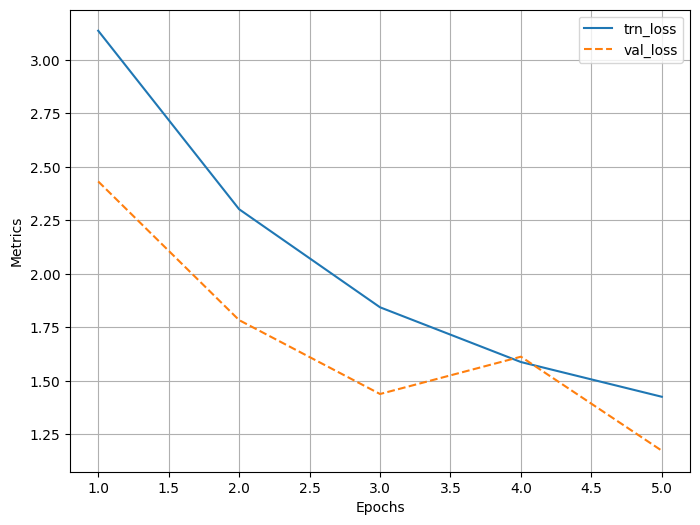

In [ ]:
log.plot_epochs('trn_loss,val_loss'.split(','))

In [ ]:
def extract_candidates(img):
    img_lbl, regions = selectivesearch.selective_search(img, scale=150, min_size=50)
    img_area = np.prod(img.shape[:2])
    candidates = []
    for r in regions:
        if r['rect'] in candidates: continue
        if r['size'] < (0.05*img_area): continue
        if r['size'] > (1*img_area): continue
        x, y, w, h = r['rect']
        candidates.append(list(r['rect']))
    return candidates


In [ ]:
def test_predictions(filename, show_output=True):
    img = np.array(cv2.imread(filename, 1)[...,::-1])
    candidates = extract_candidates(img)
    candidates = [(x,y,x+w,y+h) for x,y,w,h in candidates]
    input = []
    for candidate in candidates:
        x,y,X,Y = candidate
        crop = cv2.resize(img[y:Y,x:X], (224,224))
        input.append(preprocess_image(crop/255.)[None])
    input = torch.cat(input).to(device)
    with torch.no_grad():
        rcnn.eval()
        probs, deltas = rcnn(input)
        probs = torch.nn.functional.softmax(probs, -1)
        confs, clss = torch.max(probs, -1)
    candidates = np.array(candidates)
    confs, clss, probs, deltas = [tensor.detach().cpu().numpy() for tensor in [confs, clss, probs, deltas]]

    ixs = clss!=background_class
    confs, clss, probs, deltas, candidates = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates]]
    bbs = (candidates + deltas).astype(np.uint16)
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    confs, clss, probs, deltas, candidates, bbs = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(ixs) == 1:
        confs, clss, probs, deltas, candidates, bbs = [tensor[None] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(confs) == 0 and not show_output:
        return (0,0,224,224), 'background', 0
    if len(confs) > 0:
        best_pred = np.argmax(confs)
        best_conf = np.max(confs)
        best_bb = bbs[best_pred]
        x,y,X,Y = best_bb
    _, ax = plt.subplots(1, 2, figsize=(20,10))
    show(img, ax=ax[0])
    ax[0].grid(False)
    ax[0].set_title('Original image')
    if len(confs) == 0:
        ax[1].imshow(img)
        ax[1].set_title('No objects')
        plt.show()
        return
    ax[1].set_title(target2label[clss[best_pred]])
    show(img, bbs=bbs.tolist(), texts=[target2label[c] for c in clss.tolist()], ax=ax[1], title='predicted bounding box and class', text_sz=20)
    plt.show()
    return (x,y,X,Y),target2label[clss[best_pred]],best_conf

In [ ]:
device = 'cpu'

In [ ]:
image, crops, bbs, labels, deltas, fpath = test_ds[22]
fpath

'google_images/images/tomato/images/d8f6514e23349f16.jpg'

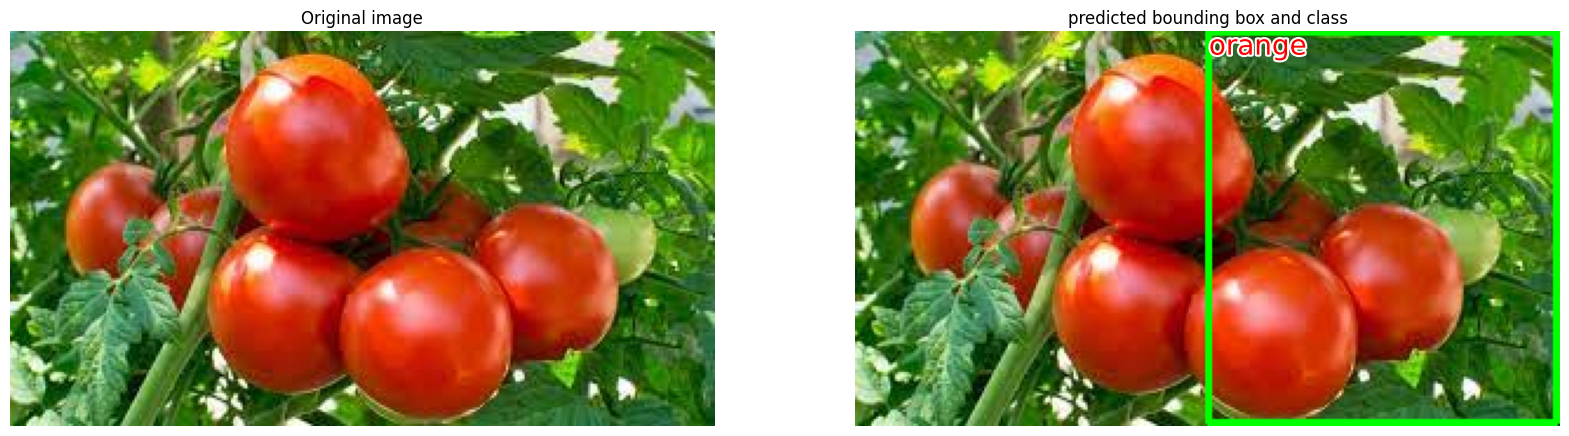

((150, 0, 298, 166), 'orange', 0.68760955)

In [ ]:
test_predictions('tomato.jpeg')

# Intento 02
- Utilizar imagenes que tengan al menos un 20% del area de las fotos
- Reducir el tamaño de la foto al ingresarlas al modelo

In [1]:
#!pip install torch_snippets selectivesearch openimages
from torch_snippets import *
import selectivesearch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models, datasets
from torchvision.ops import nms
import pandas as pd
import torch

In [3]:
!oi_download_dataset --csv_dir google_images/annotations --base_dir google_images/images --labels Carrot Tomato Apple Banana Orange Bread Cheese Mango Broccoli Grape Lemon Pineapple --format pascal --limit 1000

2023-11-22  18:08:30 INFO Downloading 481 train images for class 'carrot'
100% 481/481 [00:16<00:00, 30.06it/s]
2023-11-22  18:08:46 INFO Creating 481 train annotations (pascal) for class 'carrot'
100% 481/481 [00:00<00:00, 3849.17it/s]
2023-11-22  18:08:47 INFO Downloading 668 train images for class 'tomato'
100% 668/668 [00:22<00:00, 29.37it/s]
2023-11-22  18:09:10 INFO Creating 668 train annotations (pascal) for class 'tomato'
100% 668/668 [00:00<00:00, 4438.91it/s]
2023-11-22  18:09:10 INFO Downloading 312 train images for class 'apple'
100% 312/312 [00:11<00:00, 27.77it/s]
2023-11-22  18:09:21 INFO Creating 312 train annotations (pascal) for class 'apple'
100% 312/312 [00:00<00:00, 1936.71it/s]
2023-11-22  18:09:22 INFO Downloading 570 train images for class 'banana'
100% 570/570 [00:20<00:00, 28.01it/s]
2023-11-22  18:09:42 INFO Creating 570 train annotations (pascal) for class 'banana'
100% 570/570 [00:00<00:00, 4331.18it/s]
2023-11-22  18:09:43 INFO Downloading 758 train images

In [190]:
from PIL import Image
IMAGE_FOLDER='google_images/images'
IMAGE_CLASSES = ['apple', 'banana', 'bread', 'broccoli', 'carrot', 'cheese', 'grape', 'lemon', 'mango', 'orange', 'pineapple', 'tomato']
class ImageDataset(Dataset):
  def __init__(self, df, image_folder):
    self.df = df
    self.image_folder = image_folder
    self.unique_images = df['file_name'].unique()
  def __len__(self):
    return len(self.unique_images)
  def __getitem__(self, index):
    image_file = self.unique_images[index]
    image_df = self.df[self.df['file_name'] == image_file]
    image_class = image_df['label'].values[0]
    image_path = f'{self.image_folder}/{image_class}/images/{image_file}'
    image = cv2.imread(image_path, 1)[...,::-1] # BGR to RGB
    # Resize  images to have a width of 540
    H,W, _ = image.shape
    torch_image = torch.tensor(image.copy()).permute(2,0,1)
    new_width = 540
    scale_factor = new_width / W
    new_height = int(H * scale_factor)
    transform = transforms.Resize((new_height, new_width),antialias=True)
    torch_image = transform(torch_image)
    image = torch_image.permute(1,2,0).numpy()
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)[...,::-1]
    bboxes = image_df[['xmin', 'ymin', 'xmax', 'ymax']].values * scale_factor
    image_classes = image_df['label'].values
    return image, np.array(bboxes, dtype=np.float32), list(image_classes), image_path

In [106]:
import glob
from bs4 import BeautifulSoup
df_cols = ['file_name', 'label', 'xmin', 'ymin', 'xmax', 'ymax']
def generate_df():
  df = pd.DataFrame(columns=df_cols)
  for image_class in IMAGE_CLASSES:
    xml_files = glob.glob(f'{IMAGE_FOLDER}/{image_class}/pascal/*.xml')
    for i, xml_file in enumerate(xml_files):
      # Only 200 images per class
      if i > 300:
        break
      with open(xml_file) as f:
        soup = BeautifulSoup(f, 'xml')
        filename = soup.find('filename').text
        # Check for file size
        size = soup.find('size')
        width = int(size.find('width').text)
        height = int(size.find('height').text)
        area = width * height
        for obj in soup.find_all('object'):
          # The obj must have the class name
          if obj.find('name').text != image_class:
          	continue
          # The obj must have the bounding box
          bbox = obj.find('bndbox')
          xmin = int(bbox.find('xmin').text)
          ymin = int(bbox.find('ymin').text)
          xmax = int(bbox.find('xmax').text)
          ymax = int(bbox.find('ymax').text)
          # Calculate the bbox area
          box_width = xmax - xmin
          box_height = ymax - ymin
          box_area = abs(box_width * box_height)
          if box_area / area < 0.2:
            continue
          row_df = pd.DataFrame([[filename, image_class, xmin, ymin, xmax, ymax]], columns=df_cols)
          df = pd.concat([df, row_df], ignore_index=True)
  return df

In [42]:
images_df = generate_df()
images_df.to_csv('google_images/df.csv', index=False)

In [43]:
# Count by category
images_df['label'].value_counts()

bread        197
apple        117
banana       110
orange        64
carrot        63
cheese        57
lemon         51
tomato        33
mango         31
pineapple     23
broccoli      22
Name: label, dtype: int64

In [179]:
images_ds = ImageDataset(images_df, IMAGE_FOLDER)

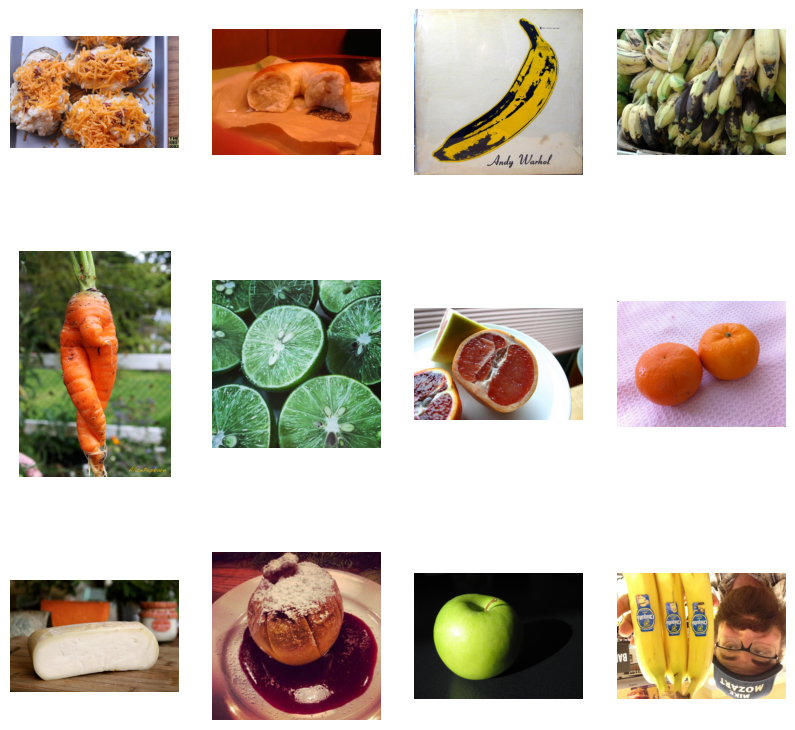

In [427]:
rows = 3
cols = 4
figure = plt.figure(figsize=(10, 10))
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(images_ds), size=(1,)).item()
    img, bbs, classes, fpath = images_ds[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")

    plt.imshow(img)
plt.show()



In [146]:
def extract_candidates(img):
    img_lbl, regions = selectivesearch.selective_search(img, scale=200, min_size=100)
    img_area = np.prod(img.shape[:2])
    candidates = []
    for r in regions:
        if r['rect'] in candidates: continue
        if r['size'] < (0.05*img_area): continue
        if r['size'] > (1*img_area): continue
        x, y, w, h = r['rect']
        candidates.append(list(r['rect']))
    return candidates
def extract_iou(boxA, boxB, epsilon=1e-5):
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])
    width = (x2 - x1)
    height = (y2 - y1)
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height
    area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    area_combined = area_a + area_b - area_overlap
    iou = area_overlap / (area_combined+epsilon)
    return iou

In [168]:
FPATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [], [], [], [], [], []
N = 720
for ix, (im, bbs, labels, fpath) in enumerate(images_ds):
    if(ix==N):
        break
    H, W, _ = im.shape
    candidates = extract_candidates(im)
    candidates = np.array([(x,y,x+w,y+h) for x,y,w,h in candidates])
    ious, rois, clss, deltas = [], [], [], []
    ious = np.array([[extract_iou(candidate, _bb_) for candidate in candidates] for _bb_ in bbs]).T
    for jx, candidate in enumerate(candidates):
        cx,cy,cX,cY = candidate
        candidate_ious = ious[jx]
        best_iou_at = np.argmax(candidate_ious)
        best_iou = candidate_ious[best_iou_at]
        best_bb = _x,_y,_X,_Y = bbs[best_iou_at]
        if best_iou > 0.3: clss.append(labels[best_iou_at])
        else : clss.append('background')
        delta = np.array([_x-cx, _y-cy, _X-cX, _Y-cY]) / np.array([W,H,W,H])
        deltas.append(delta)
        rois.append(candidate / np.array([W,H,W,H]))
    FPATHS.append(fpath)
    IOUS.append(ious)
    ROIS.append(rois)
    CLSS.append(clss)
    DELTAS.append(deltas)
    GTBBS.append(bbs)
    if ix % 10 == 0:
      print(f"Parsed {ix}/{len(images_ds)} images rows")

Parsed 0/720 images rows

Parsed 10/720 images rows

Parsed 20/720 images rows

Parsed 30/720 images rows

Parsed 40/720 images rows

Parsed 50/720 images rows

Parsed 60/720 images rows

Parsed 70/720 images rows

Parsed 80/720 images rows

Parsed 90/720 images rows

Parsed 100/720 images rows

Parsed 110/720 images rows

Parsed 120/720 images rows

Parsed 130/720 images rows

Parsed 140/720 images rows

Parsed 150/720 images rows

Parsed 160/720 images rows

Parsed 170/720 images rows

Parsed 180/720 images rows

Parsed 190/720 images rows

Parsed 200/720 images rows

Parsed 210/720 images rows

Parsed 220/720 images rows

Parsed 230/720 images rows

Parsed 240/720 images rows

Parsed 250/720 images rows

Parsed 260/720 images rows

Parsed 270/720 images rows

Parsed 280/720 images rows

Parsed 290/720 images rows

Parsed 300/720 images rows

Parsed 310/720 images rows

Parsed 320/720 images rows

Parsed 330/720 images rows

Parsed 340/720 images rows

Parsed 350/720 images rows

Parsed 360/720 images rows

Parsed 370/720 images rows

Parsed 380/720 images rows

Parsed 390/720 images rows

Parsed 400/720 images rows

Parsed 410/720 images rows

Parsed 420/720 images rows

Parsed 430/720 images rows

Parsed 440/720 images rows

Parsed 450/720 images rows

Parsed 460/720 images rows

Parsed 470/720 images rows

Parsed 480/720 images rows

Parsed 490/720 images rows

Parsed 500/720 images rows

Parsed 510/720 images rows

Parsed 520/720 images rows

Parsed 530/720 images rows

Parsed 540/720 images rows

Parsed 550/720 images rows

Parsed 560/720 images rows

Parsed 570/720 images rows

Parsed 580/720 images rows

Parsed 590/720 images rows

Parsed 600/720 images rows

Parsed 610/720 images rows

Parsed 620/720 images rows

Parsed 630/720 images rows

Parsed 640/720 images rows

Parsed 650/720 images rows

Parsed 660/720 images rows

Parsed 670/720 images rows

Parsed 680/720 images rows

Parsed 690/720 images rows

Parsed 700/720 images rows

Parsed 710/720 images rows

In [201]:
targets = pd.DataFrame(flatten(CLSS), columns=['label'])
label2target = {label: i for i, label in enumerate(targets['label'].unique())}
target2label = {i: label for i, label in enumerate(targets['label'].unique())}


In [202]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
def preprocess_image(img):
    img = torch.tensor(img).permute(2,0,1)
    img = normalize(img)
    return img.to(device).float()
def decode(_y):
    _, preds = _y.max(-1)
    return preds

In [216]:
total_length = len(FPATHS)
indices = np.arange(total_length)
np.random.shuffle(indices)
FPATHS = np.array(FPATHS)[indices.astype(int)].tolist()
GTBBS = np.array(GTBBS)[indices.astype(int)].tolist()
CLSS = np.array(CLSS)[indices.astype(int)].tolist()
DELTAS = np.array(DELTAS)[indices.astype(int)].tolist()
ROIS = np.array(ROIS)[indices.astype(int)].tolist()
IOUS = np.array(IOUS)[indices.astype(int)].tolist()

<ipython-input-216-252de55b8676>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  GTBBS = np.array(GTBBS)[indices.astype(int)].tolist()
<ipython-input-216-252de55b8676>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  CLSS = np.array(CLSS)[indices.astype(int)].tolist()
<ipython-input-216-252de55b8676>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creati

In [267]:

class RCNNDataset(Dataset):
    def __init__(self, fpaths, rois, labels, deltas, gtbbs):
        self.fpaths = fpaths
        self.gtbbs = gtbbs
        self.rois = rois
        self.labels = labels
        self.deltas = deltas
    def __len__(self): return len(self.fpaths)
    def __getitem__(self, ix):
        fpath = str(self.fpaths[ix])
        image = cv2.imread(fpath, 1)[...,::-1]
        H, W, _ = image.shape
        sh = np.array([W,H,W,H])
        gtbbs = self.gtbbs[ix]
        rois = self.rois[ix]
        bbs = (np.array(rois)*sh).astype(np.uint16)
        labels = self.labels[ix]
        deltas = self.deltas[ix]
        crops = [image[y:Y,x:X] for (x,y,X,Y) in bbs]
        return image, crops, bbs, labels, deltas, gtbbs, fpath
    def collate_fn(self, batch):
        input, rois, rixs, labels, deltas = [], [], [], [], []
        for ix in range(len(batch)):
            image, crops, image_bbs, image_labels, image_deltas, image_gt_bbs, image_fpath = batch[ix]
            crops = [cv2.resize(crop, (224,224)) for crop in crops]
            crops = [preprocess_image(crop/255.)[None] for crop in crops]
            input.extend(crops)
            labels.extend([label2target[c] for c in image_labels])
            deltas.extend(image_deltas)
        input = torch.cat(input).to(device)
        labels = torch.Tensor(labels).long().to(device)
        deltas = torch.Tensor(deltas).float().to(device)
        return input, labels, deltas

In [220]:
n_train = 9*len(FPATHS)//10
train_ds = RCNNDataset(FPATHS[:n_train], ROIS[:n_train], CLSS[:n_train], DELTAS[:n_train], GTBBS[:n_train])
test_ds = RCNNDataset(FPATHS[n_train:], ROIS[n_train:], CLSS[n_train:], DELTAS[n_train:], GTBBS[n_train:])
from torch.utils.data import TensorDataset, DataLoader
train_loader = DataLoader(train_ds, batch_size=2, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=2, collate_fn=test_ds.collate_fn, drop_last=True)

In [221]:
vgg_backbone = models.vgg16(pretrained=True)
vgg_backbone.classifier = nn.Sequential()
for param in vgg_backbone.parameters():
    param.requires_grad = False
vgg_backbone.eval().to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 197MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [222]:

class RCNN(nn.Module):
    def __init__(self):
        super().__init__()
        feature_dim = 25088
        self.backbone = vgg_backbone
        self.cls_score = nn.Linear(feature_dim, len(label2target))
        self.bbox = nn.Sequential(
              nn.Linear(feature_dim, 512),
              nn.ReLU(),
              nn.Linear(512, 4),
              nn.Tanh(),
            )
        self.cel = nn.CrossEntropyLoss()
        self.sl1 = nn.L1Loss()
    def forward(self, input):
        feat = self.backbone(input)
        cls_score = self.cls_score(feat)
        bbox = self.bbox(feat)
        return cls_score, bbox
    def calc_loss(self, probs, _deltas, labels, deltas):
        detection_loss = self.cel(probs, labels)
        ixs, = torch.where(labels != 0)
        _deltas = _deltas[ixs]
        deltas = deltas[ixs]
        self.lmb = 10.0
        if len(ixs) > 0:
            regression_loss = self.sl1(_deltas, deltas)
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss.detach()
        else:
            regression_loss = 0
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss

In [223]:
def train_batch(inputs, model, optimizer, criterion):
    input, clss, deltas = inputs
    model.train()
    optimizer.zero_grad()
    _clss, _deltas = model(input)
    loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
    accs = clss == decode(_clss)
    loss.backward()
    optimizer.step()
    return loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

In [224]:
@torch.no_grad()
def validate_batch(inputs, model, criterion):
    input, clss, deltas = inputs
    with torch.no_grad():
        model.eval()
        _clss,_deltas = model(input)
        loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
        _, _clss = _clss.max(-1)
        accs = clss == _clss
    return _clss, _deltas, loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

In [225]:
rcnn = RCNN().to(device)
criterion = rcnn.calc_loss
optimizer = optim.SGD(rcnn.parameters(), lr=1e-3)
n_epochs = 5
log = Report(n_epochs)

<ipython-input-203-23d19889ad1f>:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  deltas = torch.Tensor(deltas).float().to(device)


EPOCH: 5.000  val_loss: 1.260  val_loc_loss: 0.662  val_regr_loss: 0.060  val_acc: 0.737  (1153.33s - 0.00s remaining)

100%|██████████| 106/106 [00:00<00:00, 2515.34it/s]


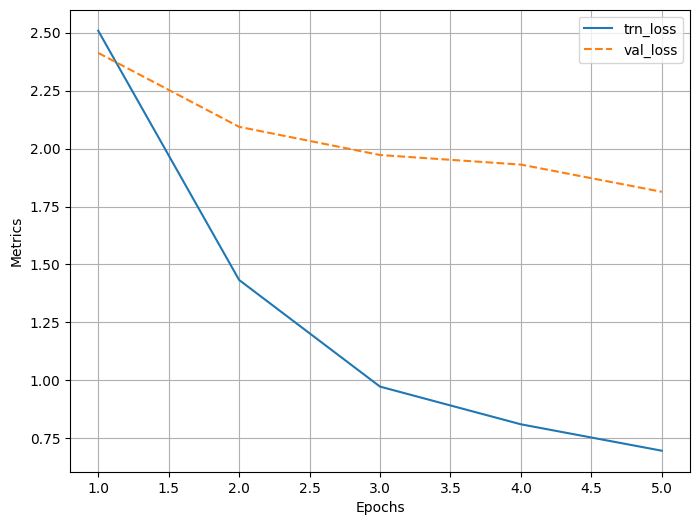

In [226]:
for epoch in range(n_epochs):

    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, loc_loss, regr_loss, accs = train_batch(inputs, rcnn,
                                                      optimizer, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss,
                   trn_regr_loss=regr_loss,
                   trn_acc=accs.mean(), end='\r')

    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        _clss, _deltas, loss, \
        loc_loss, regr_loss, accs = validate_batch(inputs,
                                                rcnn, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss,
                val_regr_loss=regr_loss,
                val_acc=accs.mean(), end='\r')

# Plotting training and validation metrics
log.plot_epochs('trn_loss,val_loss'.split(','))

In [446]:
background_class = label2target['background']
def test_predictions(filename, show_output=True):
    img = np.array(cv2.imread(filename, 1)[...,::-1])
    candidates = extract_candidates(img)
    candidates = [(x,y,x+w,y+h) for x,y,w,h in candidates]
    input = []
    for candidate in candidates:
        x,y,X,Y = candidate
        crop = cv2.resize(img[y:Y,x:X], (224,224))
        input.append(preprocess_image(crop/255.)[None])
    input = torch.cat(input).to(device)
    with torch.no_grad():
        rcnn.eval()
        probs, deltas = rcnn(input)
        probs = torch.nn.functional.softmax(probs, -1)
        confs, clss = torch.max(probs, -1)
    candidates = np.array(candidates)
    confs, clss, probs, deltas = [tensor.detach().cpu().numpy() for tensor in [confs, clss, probs, deltas]]
    ixs = clss!=background_class
    confs, clss, probs, deltas, candidates = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates]]
    bbs = (candidates + deltas).astype(np.uint16)
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    confs, clss, probs, deltas, candidates, bbs = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(ixs) == 1:
        confs, clss, probs, deltas, candidates, bbs = [tensor[None] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(confs) == 0 and not show_output:
        return (0,0,224,224), 'background', 0
    if len(confs) > 0:
        best_pred = np.argmax(confs)
        best_conf = np.max(confs)
        best_bb = bbs[best_pred]
        x,y,X,Y = best_bb
    _, ax = plt.subplots(1, 2, figsize=(20,10))
    show(img, ax=ax[0])
    ax[0].grid(False)
    ax[0].set_title('Original image')
    if len(confs) == 0:
        ax[1].imshow(img)
        ax[1].set_title('No objects')
        plt.show()
        return
    ax[1].set_title(target2label[clss[best_pred]])
    show(img, bbs=bbs.tolist(), texts=[target2label[c] for c in clss.tolist()], ax=ax[1], title='predicted bounding box and class', text_sz=20)
    plt.show()
    return (x,y,X,Y),[target2label[c] for c in clss.tolist()],best_conf

In [247]:
torch.save(rcnn.to('cpu').state_dict(), 'model02.pth')

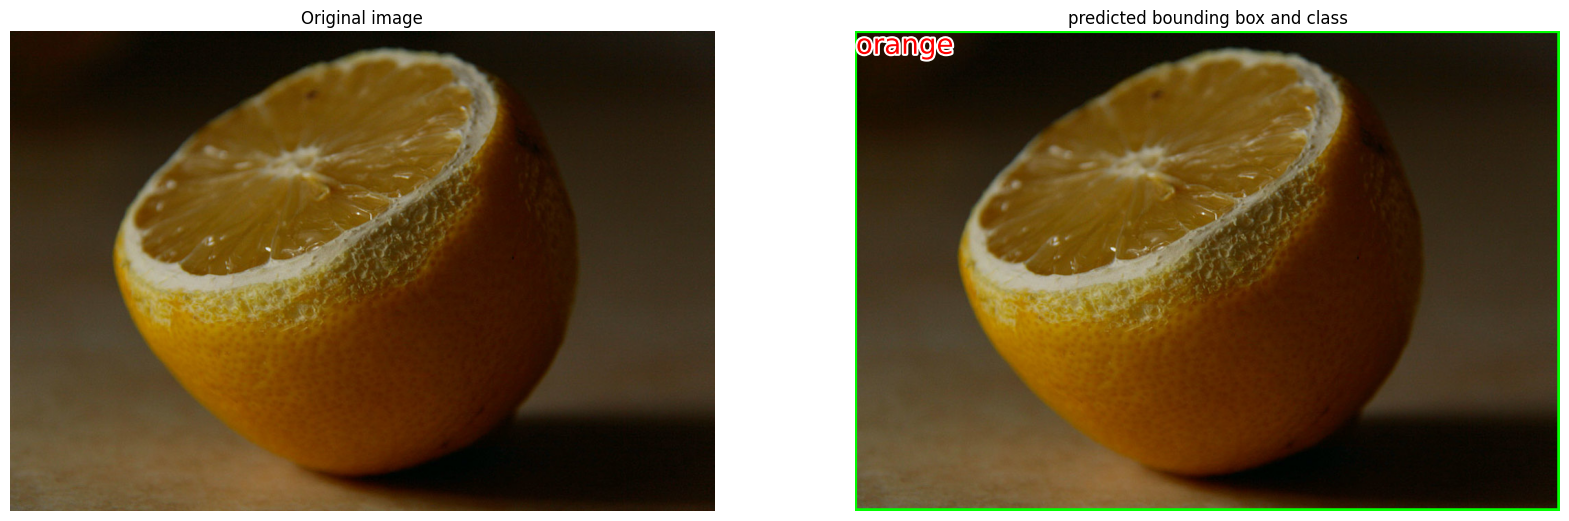

((0, 0, 1022, 695), 'orange', 0.9886783)

In [428]:
image, crops, bbs, labels, deltas, gtbbs, fpath = test_ds[12]
test_predictions(fpath)

# Intento 03
- Mas épocas
- Data augmentation

In [409]:
n_epochs=10
from imgaug import augmenters as iaa
aug = iaa.Sequential(
    [
        iaa.GaussianBlur(sigma=(0,0.25))
    ]
)

In [410]:

class RCNNDataset(Dataset):
    def __init__(self, fpaths, rois, labels, deltas, gtbbs, aug=None):
        self.fpaths = fpaths
        self.gtbbs = gtbbs
        self.rois = rois
        self.labels = labels
        self.deltas = deltas
        self.aug = aug
    def __len__(self): return len(self.fpaths)
    def __getitem__(self, ix):
        fpath = str(self.fpaths[ix])
        image = cv2.imread(fpath, 1)[...,::-1]
        H, W, _ = image.shape
        sh = np.array([W,H,W,H])
        gtbbs = self.gtbbs[ix]
        rois = self.rois[ix]
        bbs = (np.array(rois)*sh).astype(np.uint16)
        labels = self.labels[ix]
        deltas = self.deltas[ix]
        crops = [image[y:Y,x:X] for (x,y,X,Y) in bbs]
        return image, crops, bbs, labels, deltas, gtbbs, fpath
    def collate_fn(self, batch):
        input, rois, rixs, labels, deltas = [], [], [], [], []
        for ix in range(len(batch)):
            image, crops, image_bbs, image_labels, image_deltas, image_gt_bbs, image_fpath = batch[ix]
            crops = [cv2.resize(crop, (224,224)) for crop in crops]
            if self.aug != None: crops = self.aug.augment_images(images=crops)
            crops = [preprocess_image(crop/255.)[None] for crop in crops]
            input.extend(crops)
            labels.extend([label2target[c] for c in image_labels])
            deltas.extend(image_deltas)
        input = torch.cat(input).to(device)
        labels = torch.Tensor(labels).long().to(device)
        deltas = torch.Tensor(deltas).float().to(device)
        return input, labels, deltas

n_train = 9*len(FPATHS)//10
train_ds = RCNNDataset(FPATHS[:n_train], ROIS[:n_train], CLSS[:n_train], DELTAS[:n_train], GTBBS[:n_train],aug=aug)
test_ds = RCNNDataset(FPATHS[n_train:], ROIS[n_train:], CLSS[n_train:], DELTAS[n_train:], GTBBS[n_train:],aug=aug)
from torch.utils.data import TensorDataset, DataLoader
train_loader = DataLoader(train_ds, batch_size=2, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=2, collate_fn=test_ds.collate_fn, drop_last=True)

In [411]:
rcnn = RCNN().to(device)
criterion = rcnn.calc_loss
optimizer = optim.SGD(rcnn.parameters(), lr=1e-3)
log = Report(n_epochs)


EPOCH: 10.000  val_loss: 1.167  val_loc_loss: 0.535  val_regr_loss: 0.063  val_acc: 0.803  (2218.79s - 0.00s remaining)

100%|██████████| 111/111 [00:00<00:00, 1387.51it/s]


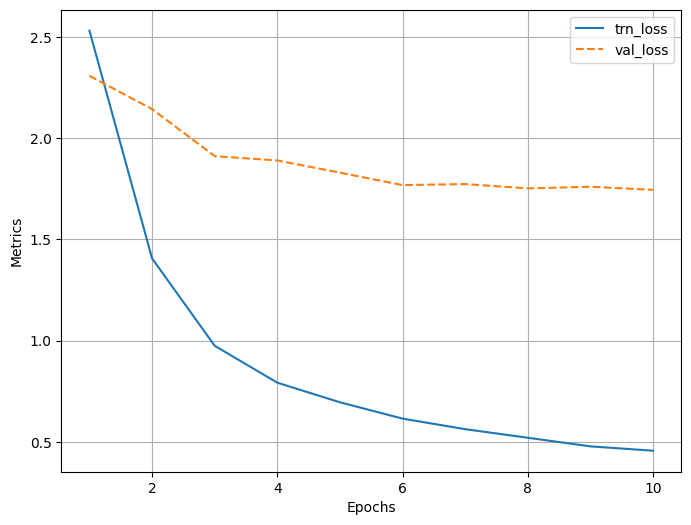

In [412]:
for epoch in range(n_epochs):

    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, loc_loss, regr_loss, accs = train_batch(inputs, rcnn,
                                                      optimizer, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss,
                   trn_regr_loss=regr_loss,
                   trn_acc=accs.mean(), end='\r')

    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        _clss, _deltas, loss, \
        loc_loss, regr_loss, accs = validate_batch(inputs,
                                                rcnn, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss,
                val_regr_loss=regr_loss,
                val_acc=accs.mean(), end='\r')

# Plotting training and validation metrics
log.plot_epochs('trn_loss,val_loss'.split(','))

In [415]:
torch.save(rcnn.to('cpu').state_dict(), 'model03.pth')
rcnn.to(device)

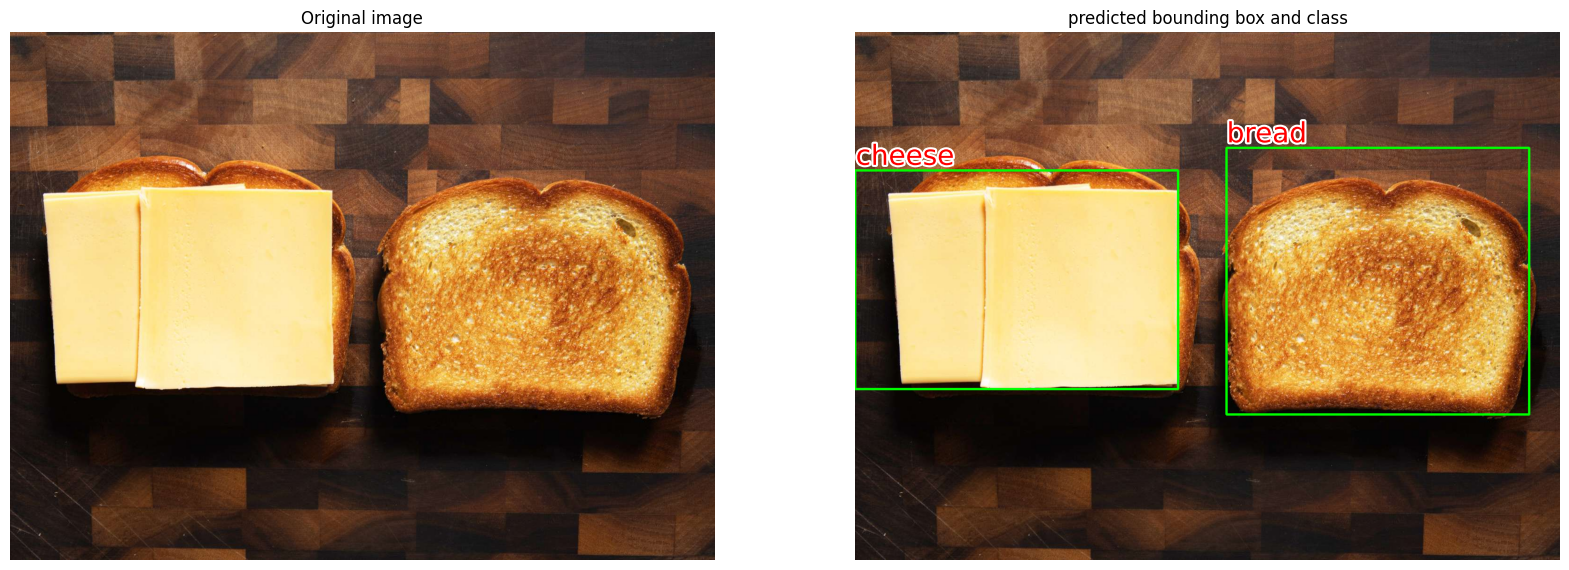

((790, 248, 1434, 815), ['bread', 'cheese'], 0.99678457)

In [454]:
background_class = label2target['background']
def test_predictions(filename, show_output=True):
    img = np.array(cv2.imread(filename, 1)[...,::-1])
    candidates = extract_candidates(img)
    candidates = [(x,y,x+w,y+h) for x,y,w,h in candidates]
    input = []
    for candidate in candidates:
        x,y,X,Y = candidate
        crop = cv2.resize(img[y:Y,x:X], (224,224))
        input.append(preprocess_image(crop/255.)[None])
    input = torch.cat(input).to(device)
    with torch.no_grad():
        rcnn.eval()
        probs, deltas = rcnn(input)
        probs = torch.nn.functional.softmax(probs, -1)
        confs, clss = torch.max(probs, -1)
    candidates = np.array(candidates)
    confs, clss, probs, deltas = [tensor.detach().cpu().numpy() for tensor in [confs, clss, probs, deltas]]
    ixs = clss!=background_class
    confs, clss, probs, deltas, candidates = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates]]
    bbs = (candidates + deltas).astype(np.uint16)
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    confs, clss, probs, deltas, candidates, bbs = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(ixs) == 1:
        confs, clss, probs, deltas, candidates, bbs = [tensor[None] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(confs) == 0 and not show_output:
        return (0,0,224,224), 'background', 0
    if len(confs) > 0:
        best_pred = np.argmax(confs)
        best_conf = np.max(confs)
        best_bb = bbs[best_pred]
        x,y,X,Y = best_bb
    _, ax = plt.subplots(1, 2, figsize=(20,10))
    show(img, ax=ax[0])
    ax[0].grid(False)
    ax[0].set_title('Original image')
    if len(confs) == 0:
        ax[1].imshow(img)
        ax[1].set_title('No objects')
        plt.show()
        return
    ax[1].set_title(target2label[clss[best_pred]])
    show(img, bbs=bbs.tolist(), texts=[target2label[c] for c in clss.tolist()], ax=ax[1], title='predicted bounding box and class', text_sz=20)
    plt.show()
    return (x,y,X,Y),[target2label[c] for c in clss.tolist()],best_conf
test_predictions('bche.jpeg')